In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
path = os.getcwd()

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16554615094658173076
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14889790133648503370
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


* 데이터셋

In [3]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


* test_1
매우 성능이 떨어지는 pre_weak_learner 사용하는 경우

In [262]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Weakcnn(tf.keras.Model): 
    def __init__(self,): 
        super(Weakcnn, self).__init__()

        self.layer_1 = CBR2d(out_channels = 4) 
        self.layer_2 = CBR2d(out_channels= 32)
        # self.layer_3 = CBR2d(out_channels = 128)
        # self.layer_4 = CBR2d(out_channels = 256)
        # self.layer_5 = CBR2d(out_channels = 512)
        # self.layer_6 = CBR2d(out_channels = 256)
        # self.layer_7 = CBR2d(out_channels = 128)
        # self.layer_8 = CBR2d(out_channels = 64)



        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        x = self.layer_1(input)
        x = self.layer_2(x)
        # x = self.layer_3(x)
        # x = self.layer_4(x)
        # x = self.layer_5(x)
        # x = self.layer_6(x)
        # x = self.layer_7(x)
        # x = self.layer_8(x)
        x = self.outlayer(x)
        return x

In [263]:
class Restree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,
        # pre_weak_net: Weakcnn,
        pre_weak_net = None,


    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        if pre_weak_net is None: # 사전모델 있는 첫노드가 아닌경우 이미 y값 잔차이기 때문에 그냥 쓰면됨
            # self.y_val = y_val   ### 여기서 모델 시작되자마자 y_val을 사전학습모델과 y와의 잔차로 피팅하기##
            # self.y_val = y_val - pre_weak_net(x_train).numpy() 
            self.y_val = y_val
        else:
            self.y_val = y_val - pre_weak_net(x_train).numpy() 


        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

        self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)

        # self.weak_net = pre_weak_net


    def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        

        l_arr = np.float32(l_values)
        r_arr = np.float32(r_values)

        max_val = np.max(np.concatenate([l_arr,r_arr]))

        hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
        hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

        dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

        return dist * -1

    # def fit_weak_layer(self):
    #     x_train_tensor = tf.convert_to_tensor(self.x_val,dtype = float)
    #     # x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
    #     y_train_resize_tensor = tf.convert_to_tensor(self.y_val,dtype = float)
    #     # y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

    #     batch_size = self.minimum_sample_leaf
    #     epoch = 100
    #     buffer_len = len(x_train_tensor)
    #     n_run = np.ceil(len(x_train_tensor)/batch_size)

    #     train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
    #     shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

    #     @tf.function()
    #     def train_step(input, label, network, loss_fun,opt):
        
    #         with tf.GradientTape() as tape:
    #             ##로스 계산
    #             pred = network(input)
                
    #             loss = loss_fun(label, pred)
    #         grads = tape.gradient(loss, network.trainable_variables)
    #         opt.apply_gradients(zip(grads, network.trainable_variables))
    #         return loss

    #     weak_net = Weakcnn()
    #     weak_net(x_train_tensor[:2]).numpy()  # 콜함수 한번 실행시켜서 초기 웨이트 설정
    #     weak_net.set_weights(self.pre_weak_weights) # 프리트레인 웨이트 할당

        
    #     loss = tf.keras.losses.MeanSquaredError()
    #     optimizer = tf.keras.optimizers.Adam(0.0001)

    #     for epoc in range(epoch):
    #         count = 0

    #         for batch in shuffled_dataset.batch(batch_size).take(n_run):

    #             count += 1
    #             mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
    #             print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

    #     self.weak_net = weak_net
       


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            feat_data = self.x_val[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data.mean(axis = (1,2)) < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            # self.fit_weak_layer()
            
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                # self.weak_net = pre_weak_net
                self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.l_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.r_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
        else:
            self.is_terminal = True
            # self.fit_weak_layer()

    def predict(self ,x_arr):
        # model
        kernel_x = x_arr[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
        left_ind = kernel_x < self.best_feature_value

        input_shape = x_arr.shape

        pred_val = np.zeros(shape=(input_shape[0],input_shape[1],input_shape[2],1))
        
        x_arr_left = x_arr[left_ind]
        x_arr_right = x_arr[~left_ind]

        if self.l_tree.is_terminal:
            # pred_l = self.l_tree.weak_net(x_arr_left)
            pred_l = self.l_tree.y_val.mean(axis = 0)
        else:
            pred_l = self.l_tree.predict(x_arr_left)

        if self.r_tree.is_terminal:
            # pred_r = self.r_tree.weak_net(x_arr_right)
            pred_r = self.r_tree.y_val.mean(axis = 0)
        else:
            pred_r = self.r_tree.predict(x_arr_right)
        
        pred_val[left_ind] = pred_l
        pred_val[~left_ind] = pred_r


        return pred_val



    def get_tree_structure(self):
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info

In [264]:
class bagging_cnn():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        n_tree: int,

        pre_weak_net: Weakcnn,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        
        self.tree_bootstrap = []
        self.n_tree = n_tree

        self.pre_weak_net = pre_weak_net

    def bagging_prediction(self,x_vals):
        print(x_vals.shape)
        preds = np.mean([ind_tree.predict(x_vals) for ind_tree in self.tree_bootstrap], axis = 0)
        preds = preds + self.pre_weak_net(x_vals).numpy()

        return preds


    def bagging_train(self,):
        for i in range(self.n_tree):
            print(i)
            data_len = len(self.x_val)
            sub_sample_ind = np.random.choice(range(data_len),data_len)
            x_val_bootstraped = self.x_val[sub_sample_ind]
            y_val_bootstraped = self.y_val[sub_sample_ind]
            
            
            i_tree = Restree(pre_weak_net = self.pre_weak_net,max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_bootstraped, y_val = y_val_bootstraped, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=x_val_bootstraped.shape)
            i_tree.fit()
            self.tree_bootstrap.append(i_tree)
           
    

In [265]:
#프리트레인 weak 네트워크
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 10
epoch = 100
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

@tf.function()
def train_step(input, label, network, loss_fun,opt):

    with tf.GradientTape() as tape:
        ##로스 계산
        pred = network(input)
        
        loss = loss_fun(label, pred)
    grads = tape.gradient(loss, network.trainable_variables)
    opt.apply_gradients(zip(grads, network.trainable_variables))
    return loss

weak_net = Weakcnn()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")


batch: 1/7.0 ---epoch: 0/100--- mse-loss: 178.0888214111328
batch: 2/7.0 ---epoch: 0/100--- mse-loss: 178.85919189453125
batch: 3/7.0 ---epoch: 0/100--- mse-loss: 178.77992248535156
batch: 4/7.0 ---epoch: 0/100--- mse-loss: 178.81564331054688
batch: 5/7.0 ---epoch: 0/100--- mse-loss: 176.0945281982422
batch: 6/7.0 ---epoch: 0/100--- mse-loss: 176.7303466796875
batch: 7/7.0 ---epoch: 0/100--- mse-loss: 177.09007263183594
batch: 1/7.0 ---epoch: 1/100--- mse-loss: 174.22776794433594
batch: 2/7.0 ---epoch: 1/100--- mse-loss: 175.2861785888672
batch: 3/7.0 ---epoch: 1/100--- mse-loss: 174.8512725830078
batch: 4/7.0 ---epoch: 1/100--- mse-loss: 174.24549865722656
batch: 5/7.0 ---epoch: 1/100--- mse-loss: 173.18524169921875
batch: 6/7.0 ---epoch: 1/100--- mse-loss: 172.3175811767578
batch: 7/7.0 ---epoch: 1/100--- mse-loss: 169.99520874023438
batch: 1/7.0 ---epoch: 2/100--- mse-loss: 170.21609497070312
batch: 2/7.0 ---epoch: 2/100--- mse-loss: 169.1345672607422
batch: 3/7.0 ---epoch: 2/100---

In [266]:
bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= 5,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= [5,5],
    kernel_n= 10,

    input_shape= x_train.shape,

    n_tree= 20,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


(70, 64, 64, 4)


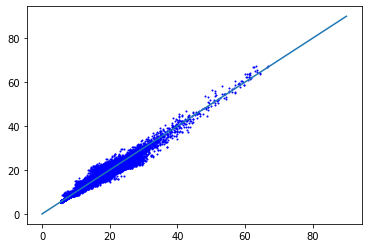

In [267]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = bagging.bagging_prediction(x_train)
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

(49, 64, 64, 4)


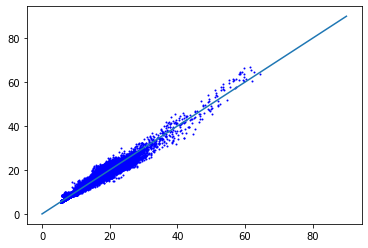

In [268]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred_test = bagging.bagging_prediction(x_test)
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

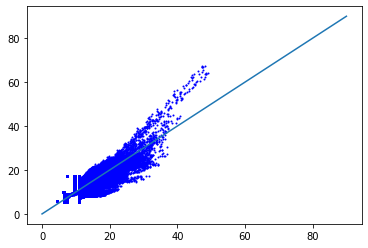

In [269]:
#weak net만 예측
pred_train_weaknet = weak_net(x_train).numpy()
plt.plot(pred_train_weaknet.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

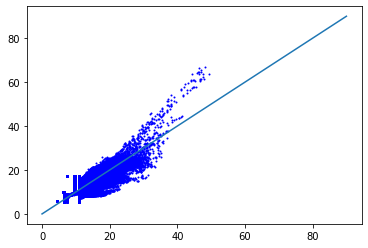

In [270]:
#weak net만 예측
pred_test_weaknet = weak_net(x_test).numpy()
plt.plot(pred_test_weaknet.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: title={'center': 'pred_weak_net'}>

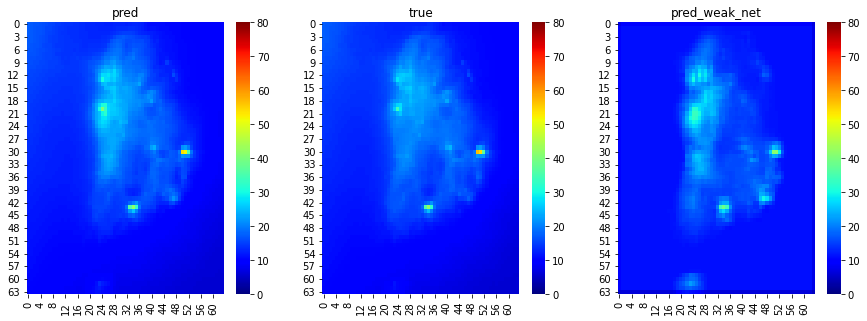

In [271]:
i = 0
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

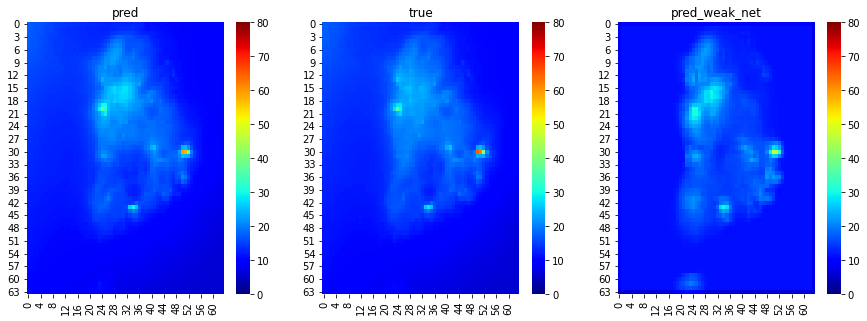

In [272]:
i = 1
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

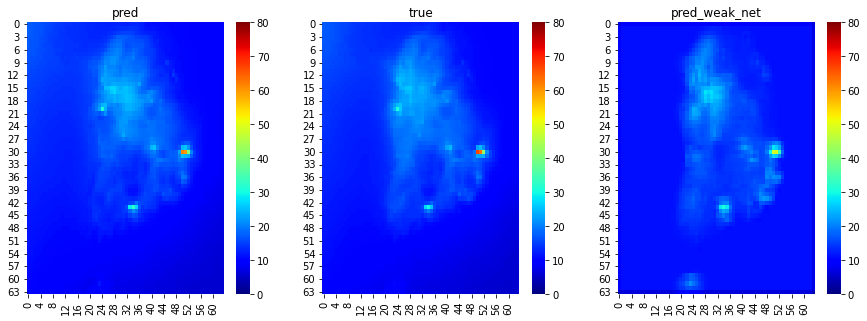

In [273]:
i = 2
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

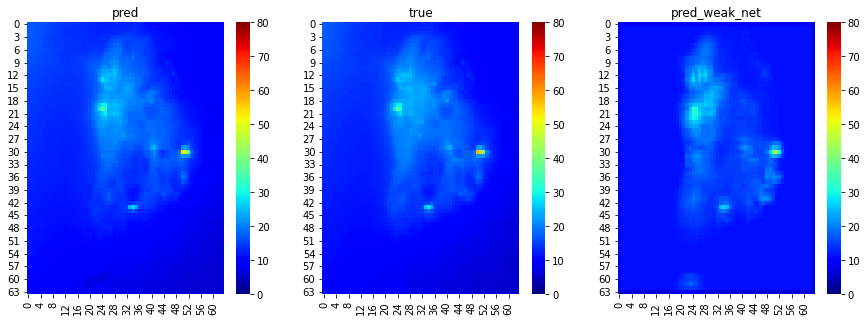

In [274]:
i = 3
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

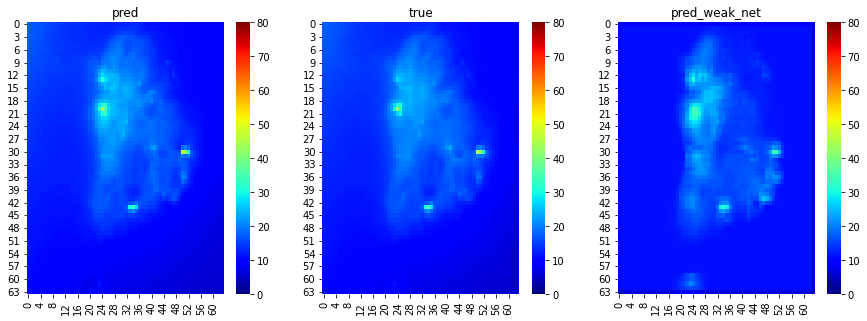

In [275]:
i = 4
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

* test_2
괜찮지만 아쉬운 성능의 pre_weak_learner 사용하는 경우

In [234]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Weakcnn(tf.keras.Model): 
    def __init__(self,): 
        super(Weakcnn, self).__init__()

        self.layer_1 = CBR2d(out_channels = 64) 
        self.layer_2 = CBR2d(out_channels= 128)
        self.layer_3 = CBR2d(out_channels = 256)
        self.layer_4 = CBR2d(out_channels = 128)
        self.layer_5 = CBR2d(out_channels = 64)
        # self.layer_6 = CBR2d(out_channels = 256)
        # self.layer_7 = CBR2d(out_channels = 128)
        # self.layer_8 = CBR2d(out_channels = 64)



        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        x = self.layer_1(input)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        # x = self.layer_6(x)
        # x = self.layer_7(x)
        # x = self.layer_8(x)
        x = self.outlayer(x)
        return x

In [235]:
class Restree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,
        # pre_weak_net: Weakcnn,
        pre_weak_net = None,


    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        if pre_weak_net is None: # 사전모델 있는 첫노드가 아닌경우 이미 y값 잔차이기 때문에 그냥 쓰면됨
            # self.y_val = y_val   ### 여기서 모델 시작되자마자 y_val을 사전학습모델과 y와의 잔차로 피팅하기##
            # self.y_val = y_val - pre_weak_net(x_train).numpy() 
            self.y_val = y_val
        else:
            self.y_val = y_val - pre_weak_net(x_train).numpy() 


        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

        self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)

        # self.weak_net = pre_weak_net


    def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        

        l_arr = np.float32(l_values)
        r_arr = np.float32(r_values)

        max_val = np.max(np.concatenate([l_arr,r_arr]))

        hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
        hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

        dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

        return dist * -1

    # def fit_weak_layer(self):
    #     x_train_tensor = tf.convert_to_tensor(self.x_val,dtype = float)
    #     # x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
    #     y_train_resize_tensor = tf.convert_to_tensor(self.y_val,dtype = float)
    #     # y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

    #     batch_size = self.minimum_sample_leaf
    #     epoch = 100
    #     buffer_len = len(x_train_tensor)
    #     n_run = np.ceil(len(x_train_tensor)/batch_size)

    #     train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
    #     shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

    #     @tf.function()
    #     def train_step(input, label, network, loss_fun,opt):
        
    #         with tf.GradientTape() as tape:
    #             ##로스 계산
    #             pred = network(input)
                
    #             loss = loss_fun(label, pred)
    #         grads = tape.gradient(loss, network.trainable_variables)
    #         opt.apply_gradients(zip(grads, network.trainable_variables))
    #         return loss

    #     weak_net = Weakcnn()
    #     weak_net(x_train_tensor[:2]).numpy()  # 콜함수 한번 실행시켜서 초기 웨이트 설정
    #     weak_net.set_weights(self.pre_weak_weights) # 프리트레인 웨이트 할당

        
    #     loss = tf.keras.losses.MeanSquaredError()
    #     optimizer = tf.keras.optimizers.Adam(0.0001)

    #     for epoc in range(epoch):
    #         count = 0

    #         for batch in shuffled_dataset.batch(batch_size).take(n_run):

    #             count += 1
    #             mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
    #             print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

    #     self.weak_net = weak_net
       


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            feat_data = self.x_val[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data.mean(axis = (1,2)) < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            # self.fit_weak_layer()
            
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                # self.weak_net = pre_weak_net
                self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.l_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.r_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
        else:
            self.is_terminal = True
            # self.fit_weak_layer()

    def predict(self ,x_arr):
        # model
        kernel_x = x_arr[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
        left_ind = kernel_x < self.best_feature_value

        input_shape = x_arr.shape

        pred_val = np.zeros(shape=(input_shape[0],input_shape[1],input_shape[2],1))
        
        x_arr_left = x_arr[left_ind]
        x_arr_right = x_arr[~left_ind]

        if self.l_tree.is_terminal:
            # pred_l = self.l_tree.weak_net(x_arr_left)
            pred_l = self.l_tree.y_val.mean(axis = 0)
        else:
            pred_l = self.l_tree.predict(x_arr_left)

        if self.r_tree.is_terminal:
            # pred_r = self.r_tree.weak_net(x_arr_right)
            pred_r = self.r_tree.y_val.mean(axis = 0)
        else:
            pred_r = self.r_tree.predict(x_arr_right)
        
        pred_val[left_ind] = pred_l
        pred_val[~left_ind] = pred_r


        return pred_val



    def get_tree_structure(self):
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info

In [236]:
class bagging_cnn():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        n_tree: int,

        pre_weak_net: Weakcnn,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        
        self.tree_bootstrap = []
        self.n_tree = n_tree

        self.pre_weak_net = pre_weak_net

    def bagging_prediction(self,x_vals):
        print(x_vals.shape)
        preds = np.mean([ind_tree.predict(x_vals) for ind_tree in self.tree_bootstrap], axis = 0)
        preds = preds + self.pre_weak_net(x_vals).numpy()

        return preds


    def bagging_train(self,):
        for i in range(self.n_tree):
            print(i)
            data_len = len(self.x_val)
            sub_sample_ind = np.random.choice(range(data_len),data_len)
            x_val_bootstraped = self.x_val[sub_sample_ind]
            y_val_bootstraped = self.y_val[sub_sample_ind]
            
            
            i_tree = Restree(pre_weak_net = self.pre_weak_net,max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_bootstraped, y_val = y_val_bootstraped, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=x_val_bootstraped.shape)
            i_tree.fit()
            self.tree_bootstrap.append(i_tree)
           
    

In [237]:
#프리트레인 weak 네트워크
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 10
epoch = 100
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

@tf.function()
def train_step(input, label, network, loss_fun,opt):

    with tf.GradientTape() as tape:
        ##로스 계산
        pred = network(input)
        
        loss = loss_fun(label, pred)
    grads = tape.gradient(loss, network.trainable_variables)
    opt.apply_gradients(zip(grads, network.trainable_variables))
    return loss

weak_net = Weakcnn()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")


batch: 1/7.0 ---epoch: 0/100--- mse-loss: 179.17135620117188
batch: 2/7.0 ---epoch: 0/100--- mse-loss: 171.5895538330078
batch: 3/7.0 ---epoch: 0/100--- mse-loss: 150.91171264648438
batch: 4/7.0 ---epoch: 0/100--- mse-loss: 111.8939437866211
batch: 5/7.0 ---epoch: 0/100--- mse-loss: 120.58186340332031
batch: 6/7.0 ---epoch: 0/100--- mse-loss: 86.35966491699219
batch: 7/7.0 ---epoch: 0/100--- mse-loss: 73.85041809082031
batch: 1/7.0 ---epoch: 1/100--- mse-loss: 68.780517578125
batch: 2/7.0 ---epoch: 1/100--- mse-loss: 55.75926971435547
batch: 3/7.0 ---epoch: 1/100--- mse-loss: 37.75644302368164
batch: 4/7.0 ---epoch: 1/100--- mse-loss: 32.20879364013672
batch: 5/7.0 ---epoch: 1/100--- mse-loss: 34.80396270751953
batch: 6/7.0 ---epoch: 1/100--- mse-loss: 17.204666137695312
batch: 7/7.0 ---epoch: 1/100--- mse-loss: 13.356302261352539
batch: 1/7.0 ---epoch: 2/100--- mse-loss: 16.37933921813965
batch: 2/7.0 ---epoch: 2/100--- mse-loss: 15.39818286895752
batch: 3/7.0 ---epoch: 2/100--- mse-l

In [238]:
bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= 5,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= [5,5],
    kernel_n= 10,

    input_shape= x_train.shape,

    n_tree= 20,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


(70, 64, 64, 4)


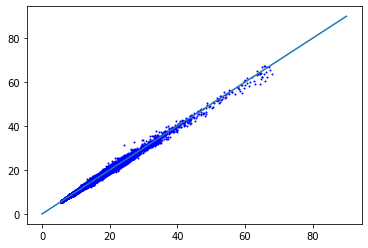

In [239]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = bagging.bagging_prediction(x_train)
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

(49, 64, 64, 4)


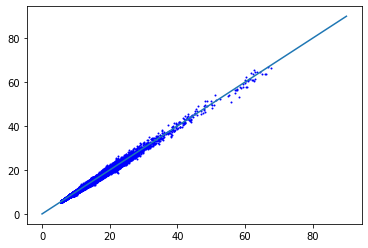

In [240]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred_test = bagging.bagging_prediction(x_test)
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

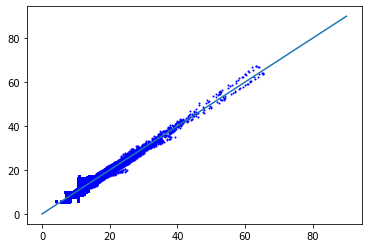

In [241]:
#weak net만 예측
pred_train_weaknet = weak_net(x_train).numpy()
plt.plot(pred_train_weaknet.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

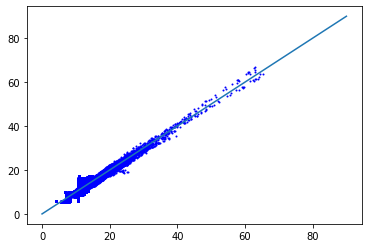

In [242]:
#weak net만 예측
pred_test_weaknet = weak_net(x_test).numpy()
plt.plot(pred_test_weaknet.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: title={'center': 'pred_weak_net'}>

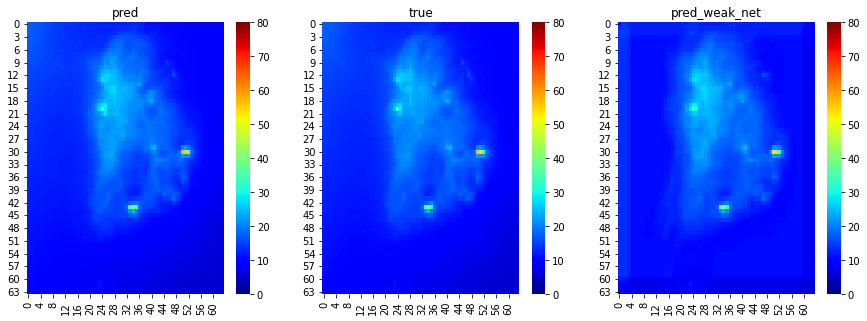

In [243]:
i = 0
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

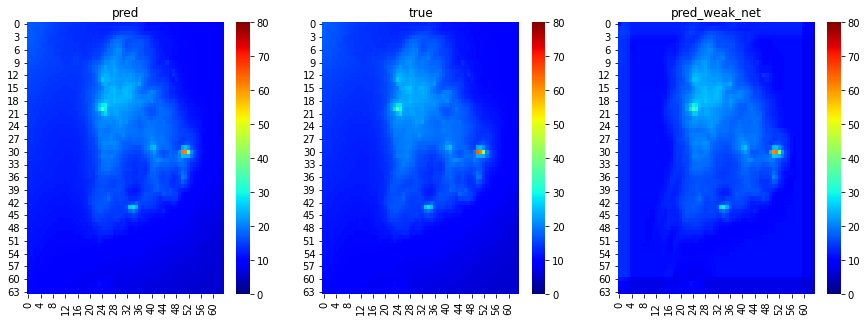

In [244]:
i = 1
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

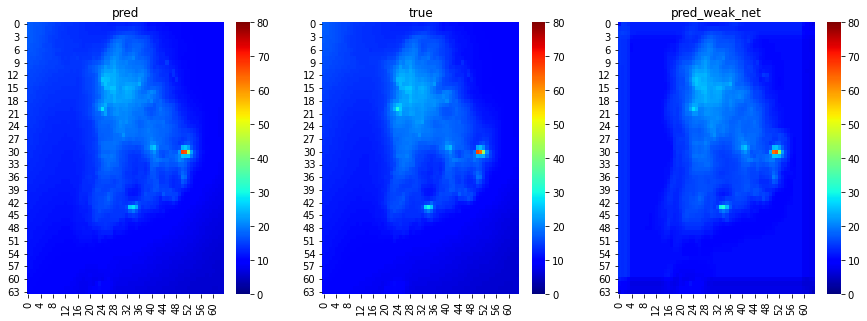

In [245]:
i = 2
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

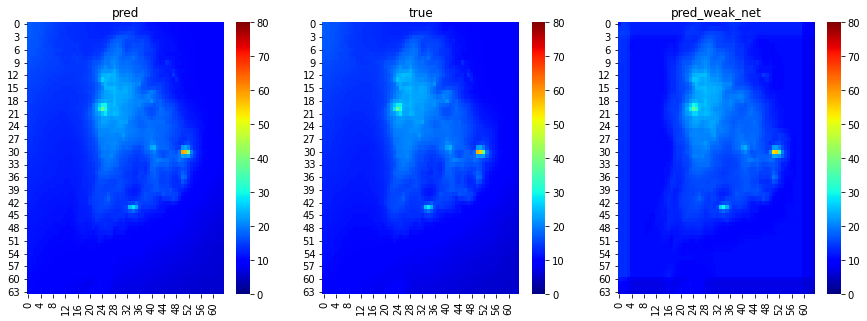

In [246]:
i = 3
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

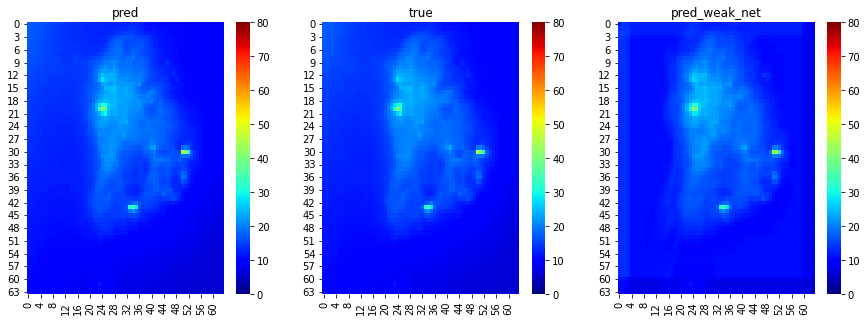

In [247]:
i = 4
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

* test_3
중간성능 pre_weak_learner 사용하는 경우

In [248]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Weakcnn(tf.keras.Model): 
    def __init__(self,): 
        super(Weakcnn, self).__init__()

        self.layer_1 = CBR2d(out_channels = 32) 
        self.layer_2 = CBR2d(out_channels= 64)
        self.layer_3 = CBR2d(out_channels = 32)
        # self.layer_4 = CBR2d(out_channels = 256)
        # self.layer_5 = CBR2d(out_channels = 512)
        # self.layer_6 = CBR2d(out_channels = 256)
        # self.layer_7 = CBR2d(out_channels = 128)
        # self.layer_8 = CBR2d(out_channels = 64)



        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        x = self.layer_1(input)
        x = self.layer_2(x)
        x = self.layer_3(x)
        # x = self.layer_4(x)
        # x = self.layer_5(x)
        # x = self.layer_6(x)
        # x = self.layer_7(x)
        # x = self.layer_8(x)
        x = self.outlayer(x)
        return x

In [249]:
class Restree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,
        # pre_weak_net: Weakcnn,
        pre_weak_net = None,


    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        if pre_weak_net is None: # 사전모델 있는 첫노드가 아닌경우 이미 y값 잔차이기 때문에 그냥 쓰면됨
            # self.y_val = y_val   ### 여기서 모델 시작되자마자 y_val을 사전학습모델과 y와의 잔차로 피팅하기##
            # self.y_val = y_val - pre_weak_net(x_train).numpy() 
            self.y_val = y_val
        else:
            self.y_val = y_val - pre_weak_net(x_train).numpy() 


        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

        self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)

        # self.weak_net = pre_weak_net


    def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        

        l_arr = np.float32(l_values)
        r_arr = np.float32(r_values)

        max_val = np.max(np.concatenate([l_arr,r_arr]))

        hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
        hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

        dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

        return dist * -1

    # def fit_weak_layer(self):
    #     x_train_tensor = tf.convert_to_tensor(self.x_val,dtype = float)
    #     # x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
    #     y_train_resize_tensor = tf.convert_to_tensor(self.y_val,dtype = float)
    #     # y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

    #     batch_size = self.minimum_sample_leaf
    #     epoch = 100
    #     buffer_len = len(x_train_tensor)
    #     n_run = np.ceil(len(x_train_tensor)/batch_size)

    #     train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
    #     shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

    #     @tf.function()
    #     def train_step(input, label, network, loss_fun,opt):
        
    #         with tf.GradientTape() as tape:
    #             ##로스 계산
    #             pred = network(input)
                
    #             loss = loss_fun(label, pred)
    #         grads = tape.gradient(loss, network.trainable_variables)
    #         opt.apply_gradients(zip(grads, network.trainable_variables))
    #         return loss

    #     weak_net = Weakcnn()
    #     weak_net(x_train_tensor[:2]).numpy()  # 콜함수 한번 실행시켜서 초기 웨이트 설정
    #     weak_net.set_weights(self.pre_weak_weights) # 프리트레인 웨이트 할당

        
    #     loss = tf.keras.losses.MeanSquaredError()
    #     optimizer = tf.keras.optimizers.Adam(0.0001)

    #     for epoc in range(epoch):
    #         count = 0

    #         for batch in shuffled_dataset.batch(batch_size).take(n_run):

    #             count += 1
    #             mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
    #             print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

    #     self.weak_net = weak_net
       


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            feat_data = self.x_val[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data.mean(axis = (1,2)) < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            # self.fit_weak_layer()
            
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                # self.weak_net = pre_weak_net
                self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.l_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.r_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
        else:
            self.is_terminal = True
            # self.fit_weak_layer()

    def predict(self ,x_arr):
        # model
        kernel_x = x_arr[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
        left_ind = kernel_x < self.best_feature_value

        input_shape = x_arr.shape

        pred_val = np.zeros(shape=(input_shape[0],input_shape[1],input_shape[2],1))
        
        x_arr_left = x_arr[left_ind]
        x_arr_right = x_arr[~left_ind]

        if self.l_tree.is_terminal:
            # pred_l = self.l_tree.weak_net(x_arr_left)
            pred_l = self.l_tree.y_val.mean(axis = 0)
        else:
            pred_l = self.l_tree.predict(x_arr_left)

        if self.r_tree.is_terminal:
            # pred_r = self.r_tree.weak_net(x_arr_right)
            pred_r = self.r_tree.y_val.mean(axis = 0)
        else:
            pred_r = self.r_tree.predict(x_arr_right)
        
        pred_val[left_ind] = pred_l
        pred_val[~left_ind] = pred_r


        return pred_val



    def get_tree_structure(self):
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info

In [250]:
class bagging_cnn():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        n_tree: int,

        pre_weak_net: Weakcnn,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        
        self.tree_bootstrap = []
        self.n_tree = n_tree

        self.pre_weak_net = pre_weak_net

    def bagging_prediction(self,x_vals):
        print(x_vals.shape)
        preds = np.mean([ind_tree.predict(x_vals) for ind_tree in self.tree_bootstrap], axis = 0)
        preds = preds + self.pre_weak_net(x_vals).numpy()

        return preds


    def bagging_train(self,):
        for i in range(self.n_tree):
            print(i)
            data_len = len(self.x_val)
            sub_sample_ind = np.random.choice(range(data_len),data_len)
            x_val_bootstraped = self.x_val[sub_sample_ind]
            y_val_bootstraped = self.y_val[sub_sample_ind]
            
            
            i_tree = Restree(pre_weak_net = self.pre_weak_net,max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_bootstraped, y_val = y_val_bootstraped, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=x_val_bootstraped.shape)
            i_tree.fit()
            self.tree_bootstrap.append(i_tree)
           
    

In [251]:
#프리트레인 weak 네트워크
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 10
epoch = 100
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

@tf.function()
def train_step(input, label, network, loss_fun,opt):

    with tf.GradientTape() as tape:
        ##로스 계산
        pred = network(input)
        
        loss = loss_fun(label, pred)
    grads = tape.gradient(loss, network.trainable_variables)
    opt.apply_gradients(zip(grads, network.trainable_variables))
    return loss

weak_net = Weakcnn()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")


batch: 1/7.0 ---epoch: 0/100--- mse-loss: 176.902099609375
batch: 2/7.0 ---epoch: 0/100--- mse-loss: 172.1332244873047
batch: 3/7.0 ---epoch: 0/100--- mse-loss: 171.18258666992188
batch: 4/7.0 ---epoch: 0/100--- mse-loss: 163.5070343017578
batch: 5/7.0 ---epoch: 0/100--- mse-loss: 159.2164764404297
batch: 6/7.0 ---epoch: 0/100--- mse-loss: 150.6043243408203
batch: 7/7.0 ---epoch: 0/100--- mse-loss: 144.32046508789062
batch: 1/7.0 ---epoch: 1/100--- mse-loss: 138.6887664794922
batch: 2/7.0 ---epoch: 1/100--- mse-loss: 128.00282287597656
batch: 3/7.0 ---epoch: 1/100--- mse-loss: 118.6802978515625
batch: 4/7.0 ---epoch: 1/100--- mse-loss: 112.36018371582031
batch: 5/7.0 ---epoch: 1/100--- mse-loss: 106.86856842041016
batch: 6/7.0 ---epoch: 1/100--- mse-loss: 101.76579284667969
batch: 7/7.0 ---epoch: 1/100--- mse-loss: 97.857666015625
batch: 1/7.0 ---epoch: 2/100--- mse-loss: 99.04947662353516
batch: 2/7.0 ---epoch: 2/100--- mse-loss: 96.99369812011719
batch: 3/7.0 ---epoch: 2/100--- mse-l

In [252]:
bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= 5,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= [5,5],
    kernel_n= 10,

    input_shape= x_train.shape,

    n_tree= 20,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


(70, 64, 64, 4)


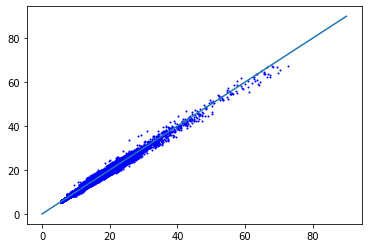

In [253]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = bagging.bagging_prediction(x_train)
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

(49, 64, 64, 4)


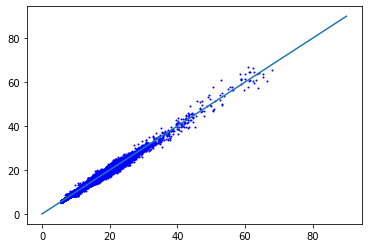

In [254]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred_test = bagging.bagging_prediction(x_test)
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

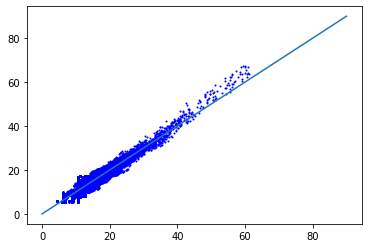

In [255]:
#weak net만 예측
pred_train_weaknet = weak_net(x_train).numpy()
plt.plot(pred_train_weaknet.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

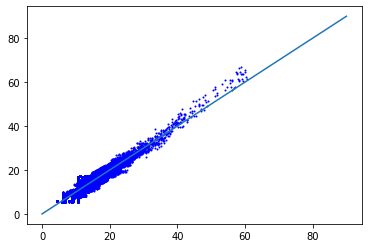

In [256]:
#weak net만 예측
pred_test_weaknet = weak_net(x_test).numpy()
plt.plot(pred_test_weaknet.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: title={'center': 'pred_weak_net'}>

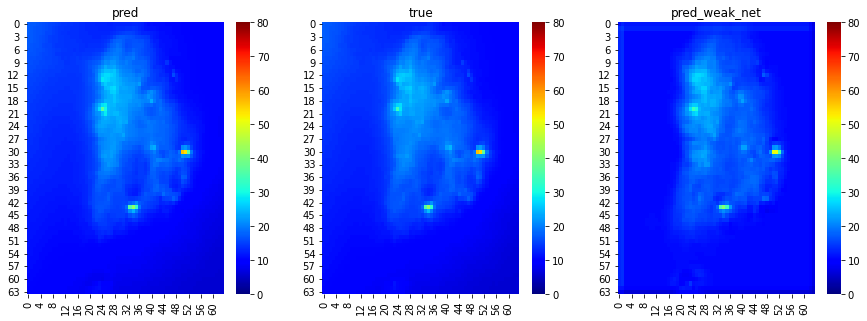

In [257]:
i = 0
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

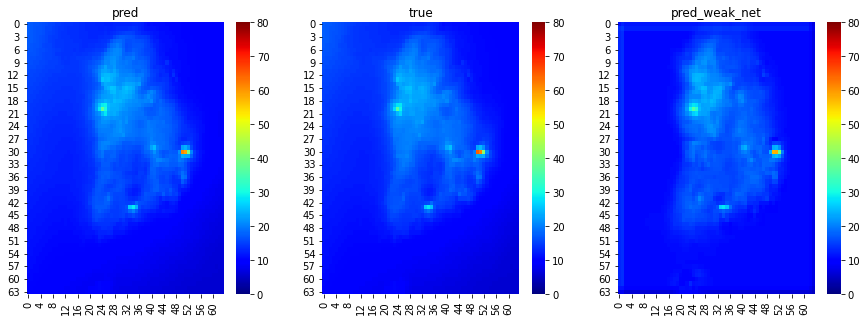

In [258]:
i = 1
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

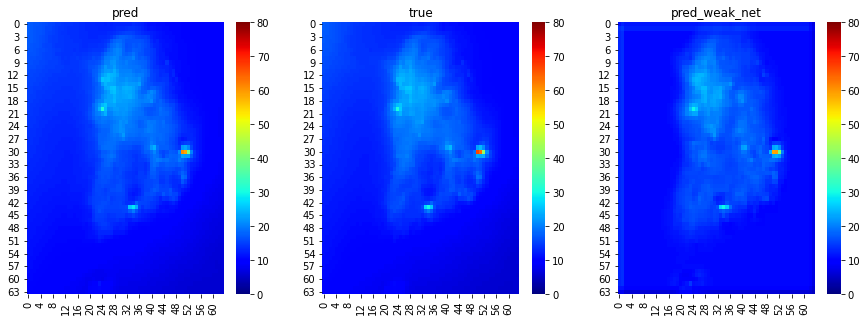

In [259]:
i = 2
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

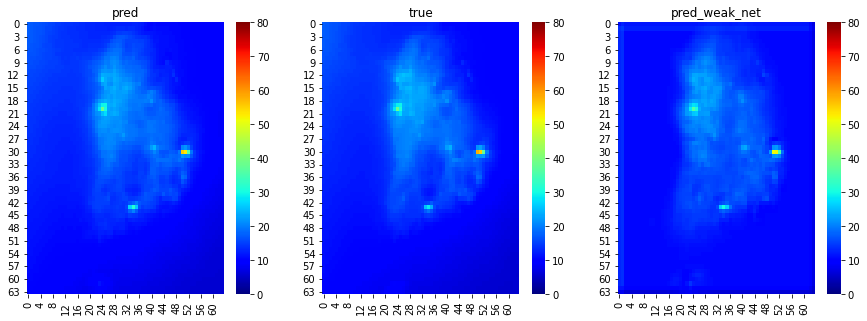

In [260]:
i = 3
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

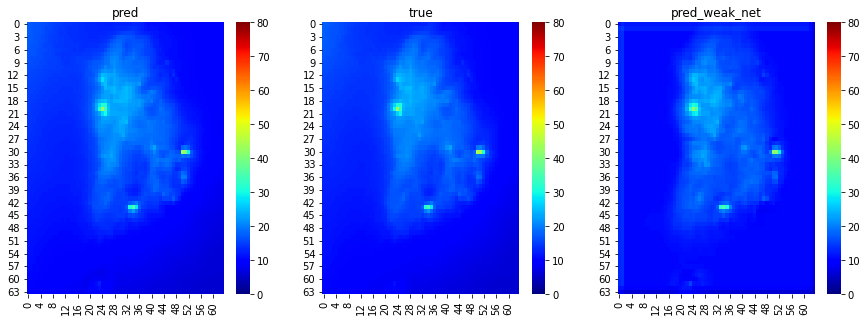

In [261]:
i = 4
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

* test_4
매우 고성능 pre_weak_learner 사용하는 경우

In [276]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Weakcnn(tf.keras.Model): 
    def __init__(self,): 
        super(Weakcnn, self).__init__()

        self.layer_1 = CBR2d(out_channels = 4) 
        self.layer_2 = CBR2d(out_channels= 32)
        self.layer_3 = CBR2d(out_channels = 128)
        self.layer_4 = CBR2d(out_channels = 256)
        self.layer_5 = CBR2d(out_channels = 512)
        self.layer_6 = CBR2d(out_channels = 256)
        self.layer_7 = CBR2d(out_channels = 128)
        self.layer_8 = CBR2d(out_channels = 64)



        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        x = self.layer_1(input)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.layer_6(x)
        x = self.layer_7(x)
        x = self.layer_8(x)
        x = self.outlayer(x)
        return x

In [277]:
class Restree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,
        # pre_weak_net: Weakcnn,
        pre_weak_net = None,


    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        if pre_weak_net is None: # 사전모델 있는 첫노드가 아닌경우 이미 y값 잔차이기 때문에 그냥 쓰면됨
            # self.y_val = y_val   ### 여기서 모델 시작되자마자 y_val을 사전학습모델과 y와의 잔차로 피팅하기##
            # self.y_val = y_val - pre_weak_net(x_train).numpy() 
            self.y_val = y_val
        else:
            self.y_val = y_val - pre_weak_net(x_train).numpy() 


        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

        self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)

        # self.weak_net = pre_weak_net


    def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        

        l_arr = np.float32(l_values)
        r_arr = np.float32(r_values)

        max_val = np.max(np.concatenate([l_arr,r_arr]))

        hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
        hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

        dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

        return dist * -1

    # def fit_weak_layer(self):
    #     x_train_tensor = tf.convert_to_tensor(self.x_val,dtype = float)
    #     # x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
    #     y_train_resize_tensor = tf.convert_to_tensor(self.y_val,dtype = float)
    #     # y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

    #     batch_size = self.minimum_sample_leaf
    #     epoch = 100
    #     buffer_len = len(x_train_tensor)
    #     n_run = np.ceil(len(x_train_tensor)/batch_size)

    #     train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
    #     shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

    #     @tf.function()
    #     def train_step(input, label, network, loss_fun,opt):
        
    #         with tf.GradientTape() as tape:
    #             ##로스 계산
    #             pred = network(input)
                
    #             loss = loss_fun(label, pred)
    #         grads = tape.gradient(loss, network.trainable_variables)
    #         opt.apply_gradients(zip(grads, network.trainable_variables))
    #         return loss

    #     weak_net = Weakcnn()
    #     weak_net(x_train_tensor[:2]).numpy()  # 콜함수 한번 실행시켜서 초기 웨이트 설정
    #     weak_net.set_weights(self.pre_weak_weights) # 프리트레인 웨이트 할당

        
    #     loss = tf.keras.losses.MeanSquaredError()
    #     optimizer = tf.keras.optimizers.Adam(0.0001)

    #     for epoc in range(epoch):
    #         count = 0

    #         for batch in shuffled_dataset.batch(batch_size).take(n_run):

    #             count += 1
    #             mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
    #             print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

    #     self.weak_net = weak_net
       


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            feat_data = self.x_val[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data.mean(axis = (1,2)) < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            # self.fit_weak_layer()
            
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                # self.weak_net = pre_weak_net
                self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.l_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.r_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
        else:
            self.is_terminal = True
            # self.fit_weak_layer()

    def predict(self ,x_arr):
        # model
        kernel_x = x_arr[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
        left_ind = kernel_x < self.best_feature_value

        input_shape = x_arr.shape

        pred_val = np.zeros(shape=(input_shape[0],input_shape[1],input_shape[2],1))
        
        x_arr_left = x_arr[left_ind]
        x_arr_right = x_arr[~left_ind]

        if self.l_tree.is_terminal:
            # pred_l = self.l_tree.weak_net(x_arr_left)
            pred_l = self.l_tree.y_val.mean(axis = 0)
        else:
            pred_l = self.l_tree.predict(x_arr_left)

        if self.r_tree.is_terminal:
            # pred_r = self.r_tree.weak_net(x_arr_right)
            pred_r = self.r_tree.y_val.mean(axis = 0)
        else:
            pred_r = self.r_tree.predict(x_arr_right)
        
        pred_val[left_ind] = pred_l
        pred_val[~left_ind] = pred_r


        return pred_val



    def get_tree_structure(self):
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info

In [278]:
class bagging_cnn():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        n_tree: int,

        pre_weak_net: Weakcnn,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        
        self.tree_bootstrap = []
        self.n_tree = n_tree

        self.pre_weak_net = pre_weak_net

    def bagging_prediction(self,x_vals):
        print(x_vals.shape)
        preds = np.mean([ind_tree.predict(x_vals) for ind_tree in self.tree_bootstrap], axis = 0)
        preds = preds + self.pre_weak_net(x_vals).numpy()

        return preds


    def bagging_train(self,):
        for i in range(self.n_tree):
            print(i)
            data_len = len(self.x_val)
            sub_sample_ind = np.random.choice(range(data_len),data_len)
            x_val_bootstraped = self.x_val[sub_sample_ind]
            y_val_bootstraped = self.y_val[sub_sample_ind]
            
            
            i_tree = Restree(pre_weak_net = self.pre_weak_net,max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_bootstraped, y_val = y_val_bootstraped, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=x_val_bootstraped.shape)
            i_tree.fit()
            self.tree_bootstrap.append(i_tree)
           
    

In [279]:
#프리트레인 weak 네트워크
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 10
epoch = 100
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

@tf.function()
def train_step(input, label, network, loss_fun,opt):

    with tf.GradientTape() as tape:
        ##로스 계산
        pred = network(input)
        
        loss = loss_fun(label, pred)
    grads = tape.gradient(loss, network.trainable_variables)
    opt.apply_gradients(zip(grads, network.trainable_variables))
    return loss

weak_net = Weakcnn()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")


batch: 1/7.0 ---epoch: 0/100--- mse-loss: 179.48464965820312
batch: 2/7.0 ---epoch: 0/100--- mse-loss: 142.59140014648438
batch: 3/7.0 ---epoch: 0/100--- mse-loss: 284.18634033203125
batch: 4/7.0 ---epoch: 0/100--- mse-loss: 109.0374755859375
batch: 5/7.0 ---epoch: 0/100--- mse-loss: 148.7089385986328
batch: 6/7.0 ---epoch: 0/100--- mse-loss: 161.134765625
batch: 7/7.0 ---epoch: 0/100--- mse-loss: 162.9132080078125
batch: 1/7.0 ---epoch: 1/100--- mse-loss: 160.80035400390625
batch: 2/7.0 ---epoch: 1/100--- mse-loss: 158.6591033935547
batch: 3/7.0 ---epoch: 1/100--- mse-loss: 152.3019256591797
batch: 4/7.0 ---epoch: 1/100--- mse-loss: 143.91539001464844
batch: 5/7.0 ---epoch: 1/100--- mse-loss: 128.24078369140625
batch: 6/7.0 ---epoch: 1/100--- mse-loss: 105.0606689453125
batch: 7/7.0 ---epoch: 1/100--- mse-loss: 73.3782730102539
batch: 1/7.0 ---epoch: 2/100--- mse-loss: 35.20582580566406
batch: 2/7.0 ---epoch: 2/100--- mse-loss: 19.94872283935547
batch: 3/7.0 ---epoch: 2/100--- mse-los

In [280]:
bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= 5,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= [5,5],
    kernel_n= 10,

    input_shape= x_train.shape,

    n_tree= 20,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


(70, 64, 64, 4)


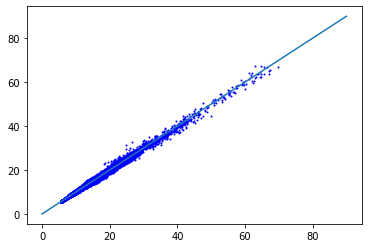

In [281]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = bagging.bagging_prediction(x_train)
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

(49, 64, 64, 4)


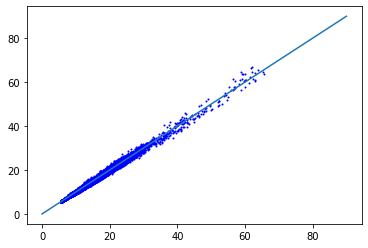

In [282]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred_test = bagging.bagging_prediction(x_test)
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

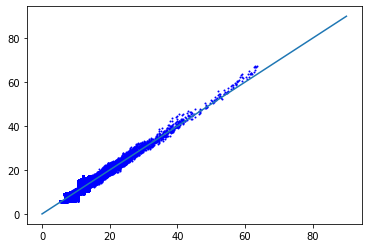

In [283]:
#weak net만 예측
pred_train_weaknet = weak_net(x_train).numpy()
plt.plot(pred_train_weaknet.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

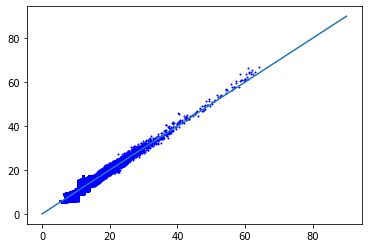

In [284]:
#weak net만 예측
pred_test_weaknet = weak_net(x_test).numpy()
plt.plot(pred_test_weaknet.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: title={'center': 'pred_weak_net'}>

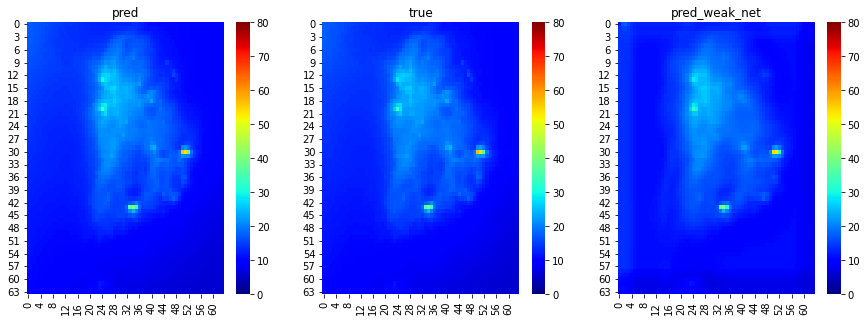

In [285]:
i = 0
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

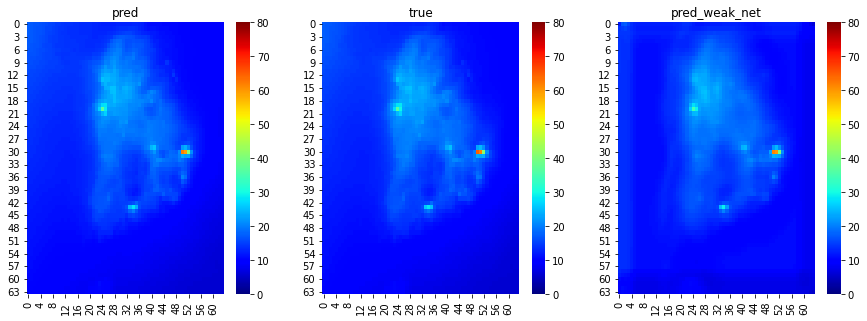

In [286]:
i = 1
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

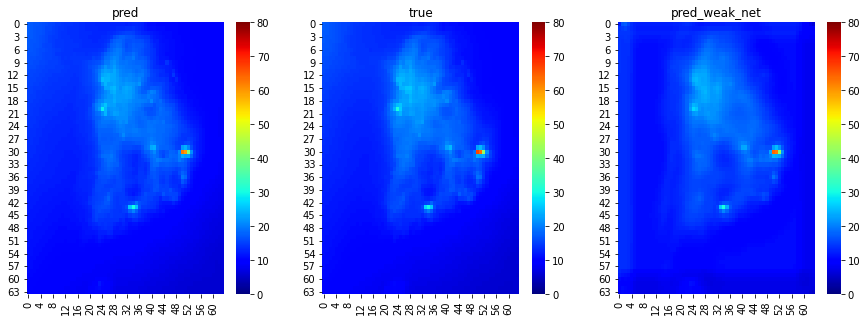

In [287]:
i = 2
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

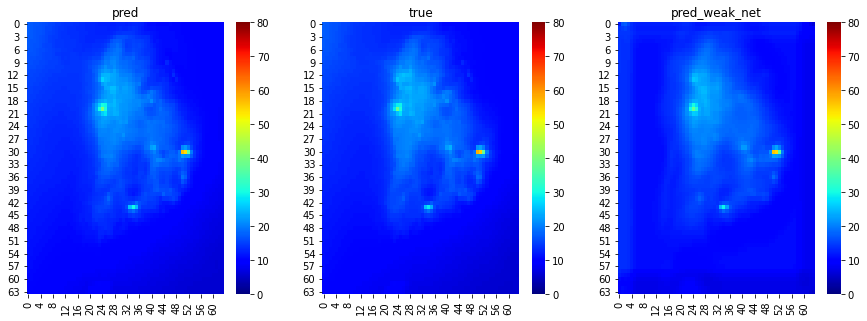

In [288]:
i = 3
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

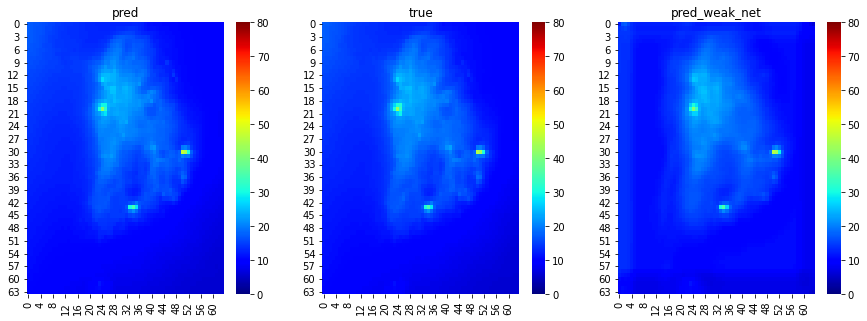

In [289]:
i = 4
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

* 완전 과소적합상태

In [ ]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Weakcnn(tf.keras.Model): 
    def __init__(self,): 
        super(Weakcnn, self).__init__()

        self.layer_1 = CBR2d(out_channels = 32) 
        self.layer_2 = CBR2d(out_channels= 64)
        self.layer_3 = CBR2d(out_channels = 128)
        self.layer_4 = CBR2d(out_channels = 64)
        # self.layer_5 = CBR2d(out_channels = 512)
        # self.layer_6 = CBR2d(out_channels = 256)
        # self.layer_7 = CBR2d(out_channels = 128)
        # self.layer_8 = CBR2d(out_channels = 64)



        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        x = self.layer_1(input)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        # x = self.layer_5(x)
        # x = self.layer_6(x)
        # x = self.layer_7(x)
        # x = self.layer_8(x)
        x = self.outlayer(x)
        return x

In [ ]:
class Restree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,
        # pre_weak_net: Weakcnn,
        pre_weak_net = None,


    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        if pre_weak_net is None: # 사전모델 있는 첫노드가 아닌경우 이미 y값 잔차이기 때문에 그냥 쓰면됨
            # self.y_val = y_val   ### 여기서 모델 시작되자마자 y_val을 사전학습모델과 y와의 잔차로 피팅하기##
            # self.y_val = y_val - pre_weak_net(x_train).numpy() 
            self.y_val = y_val
        else:
            self.y_val = y_val - pre_weak_net(x_train).numpy() 


        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

        self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)

        # self.weak_net = pre_weak_net


    def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        

        l_arr = np.float32(l_values)
        r_arr = np.float32(r_values)

        max_val = np.max(np.concatenate([l_arr,r_arr]))

        hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
        hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

        dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

        return dist * -1

    # def fit_weak_layer(self):
    #     x_train_tensor = tf.convert_to_tensor(self.x_val,dtype = float)
    #     # x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
    #     y_train_resize_tensor = tf.convert_to_tensor(self.y_val,dtype = float)
    #     # y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

    #     batch_size = self.minimum_sample_leaf
    #     epoch = 100
    #     buffer_len = len(x_train_tensor)
    #     n_run = np.ceil(len(x_train_tensor)/batch_size)

    #     train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
    #     shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

    #     @tf.function()
    #     def train_step(input, label, network, loss_fun,opt):
        
    #         with tf.GradientTape() as tape:
    #             ##로스 계산
    #             pred = network(input)
                
    #             loss = loss_fun(label, pred)
    #         grads = tape.gradient(loss, network.trainable_variables)
    #         opt.apply_gradients(zip(grads, network.trainable_variables))
    #         return loss

    #     weak_net = Weakcnn()
    #     weak_net(x_train_tensor[:2]).numpy()  # 콜함수 한번 실행시켜서 초기 웨이트 설정
    #     weak_net.set_weights(self.pre_weak_weights) # 프리트레인 웨이트 할당

        
    #     loss = tf.keras.losses.MeanSquaredError()
    #     optimizer = tf.keras.optimizers.Adam(0.0001)

    #     for epoc in range(epoch):
    #         count = 0

    #         for batch in shuffled_dataset.batch(batch_size).take(n_run):

    #             count += 1
    #             mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
    #             print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

    #     self.weak_net = weak_net
       


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            feat_data = self.x_val[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data.mean(axis = (1,2)) < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            # self.fit_weak_layer()
            
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                # self.weak_net = pre_weak_net
                self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.l_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.r_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
        else:
            self.is_terminal = True
            # self.fit_weak_layer()

    def predict(self ,x_arr):
        # model
        kernel_x = x_arr[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
        left_ind = kernel_x < self.best_feature_value

        input_shape = x_arr.shape

        pred_val = np.zeros(shape=(input_shape[0],input_shape[1],input_shape[2],1))
        
        x_arr_left = x_arr[left_ind]
        x_arr_right = x_arr[~left_ind]

        if self.l_tree.is_terminal:
            # pred_l = self.l_tree.weak_net(x_arr_left)
            pred_l = self.l_tree.y_val.mean(axis = 0)
        else:
            pred_l = self.l_tree.predict(x_arr_left)

        if self.r_tree.is_terminal:
            # pred_r = self.r_tree.weak_net(x_arr_right)
            pred_r = self.r_tree.y_val.mean(axis = 0)
        else:
            pred_r = self.r_tree.predict(x_arr_right)
        
        pred_val[left_ind] = pred_l
        pred_val[~left_ind] = pred_r


        return pred_val



    def get_tree_structure(self):
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info

In [ ]:
class bagging_cnn():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        n_tree: int,

        pre_weak_net: Weakcnn,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        
        self.tree_bootstrap = []
        self.n_tree = n_tree

        self.pre_weak_net = pre_weak_net

    def bagging_prediction(self,x_vals):
        print(x_vals.shape)
        preds = np.mean([ind_tree.predict(x_vals) for ind_tree in self.tree_bootstrap], axis = 0)
        preds = preds + self.pre_weak_net(x_vals).numpy()

        return preds


    def bagging_train(self,):
        for i in range(self.n_tree):
            print(i)
            data_len = len(self.x_val)
            sub_sample_ind = np.random.choice(range(data_len),data_len)
            x_val_bootstraped = self.x_val[sub_sample_ind]
            y_val_bootstraped = self.y_val[sub_sample_ind]
            
            
            i_tree = Restree(pre_weak_net = self.pre_weak_net,max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_bootstraped, y_val = y_val_bootstraped, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=x_val_bootstraped.shape)
            i_tree.fit()
            self.tree_bootstrap.append(i_tree)
           
    

In [ ]:
#프리트레인 weak 네트워크
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 10
epoch = 10
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

@tf.function()
def train_step(input, label, network, loss_fun,opt):

    with tf.GradientTape() as tape:
        ##로스 계산
        pred = network(input)
        
        loss = loss_fun(label, pred)
    grads = tape.gradient(loss, network.trainable_variables)
    opt.apply_gradients(zip(grads, network.trainable_variables))
    return loss

weak_net = Weakcnn()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")


batch: 1/7.0 ---epoch: 0/10--- mse-loss: 177.3653564453125
batch: 2/7.0 ---epoch: 0/10--- mse-loss: 174.8217315673828
batch: 3/7.0 ---epoch: 0/10--- mse-loss: 168.39334106445312
batch: 4/7.0 ---epoch: 0/10--- mse-loss: 161.861328125
batch: 5/7.0 ---epoch: 0/10--- mse-loss: 150.8756103515625
batch: 6/7.0 ---epoch: 0/10--- mse-loss: 131.9735107421875
batch: 7/7.0 ---epoch: 0/10--- mse-loss: 111.03684997558594
batch: 1/7.0 ---epoch: 1/10--- mse-loss: 97.2932357788086
batch: 2/7.0 ---epoch: 1/10--- mse-loss: 108.8792495727539
batch: 3/7.0 ---epoch: 1/10--- mse-loss: 100.27174377441406
batch: 4/7.0 ---epoch: 1/10--- mse-loss: 81.60054016113281
batch: 5/7.0 ---epoch: 1/10--- mse-loss: 71.9742660522461
batch: 6/7.0 ---epoch: 1/10--- mse-loss: 63.718177795410156
batch: 7/7.0 ---epoch: 1/10--- mse-loss: 58.54094696044922
batch: 1/7.0 ---epoch: 2/10--- mse-loss: 51.54608154296875
batch: 2/7.0 ---epoch: 2/10--- mse-loss: 42.54190444946289
batch: 3/7.0 ---epoch: 2/10--- mse-loss: 30.91915512084961

In [ ]:
bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= 5,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= [5,5],
    kernel_n= 10,

    input_shape= x_train.shape,

    n_tree= 20,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


(70, 64, 64, 4)


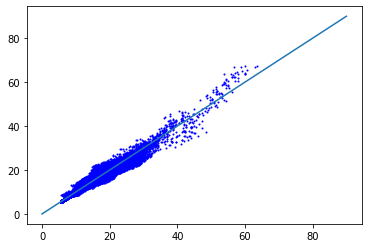

In [ ]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = bagging.bagging_prediction(x_train)
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

(49, 64, 64, 4)


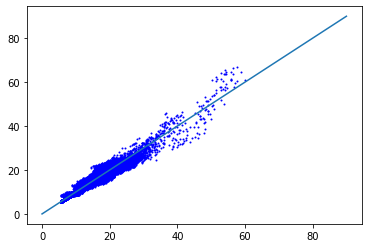

In [ ]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred_test = bagging.bagging_prediction(x_test)
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

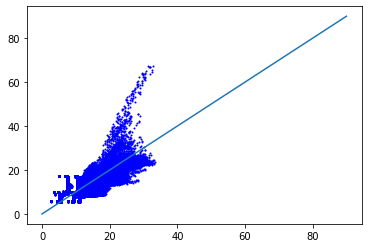

In [ ]:
#weak net만 예측
pred_train_weaknet = weak_net(x_train).numpy()
plt.plot(pred_train_weaknet.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

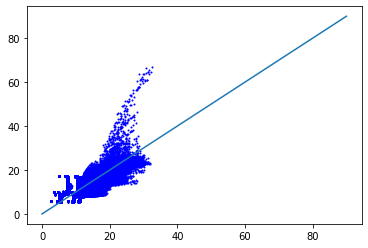

In [ ]:
#weak net만 예측
pred_test_weaknet = weak_net(x_test).numpy()
plt.plot(pred_test_weaknet.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: title={'center': 'pred_weak_net'}>

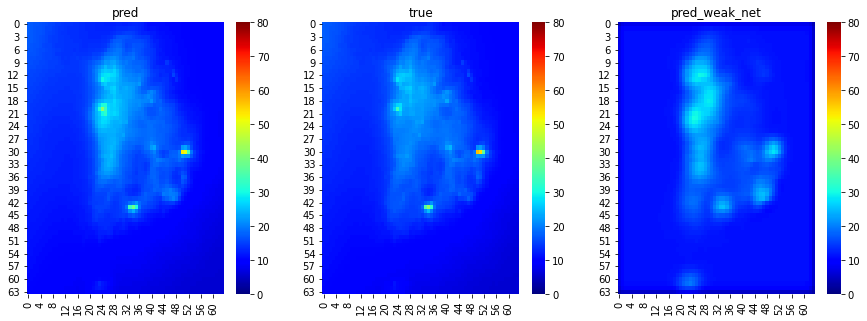

In [ ]:
i = 0
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

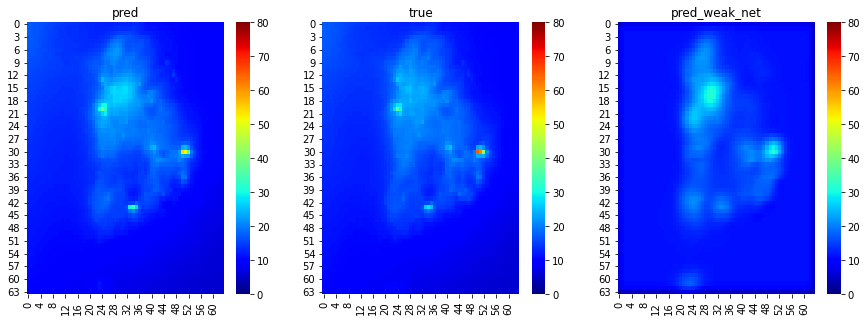

In [ ]:
i = 1
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

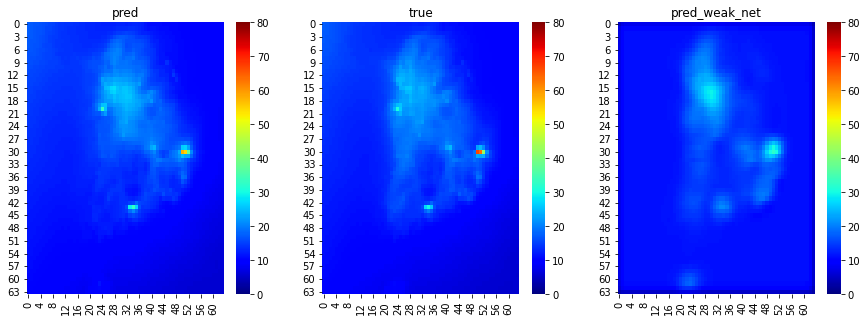

In [ ]:
i = 2
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

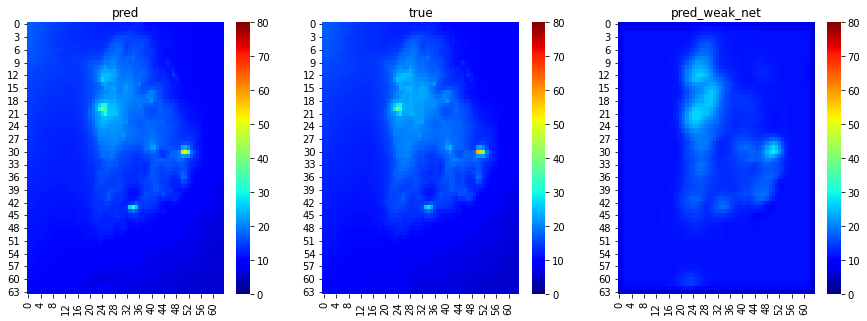

In [ ]:
i = 3
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

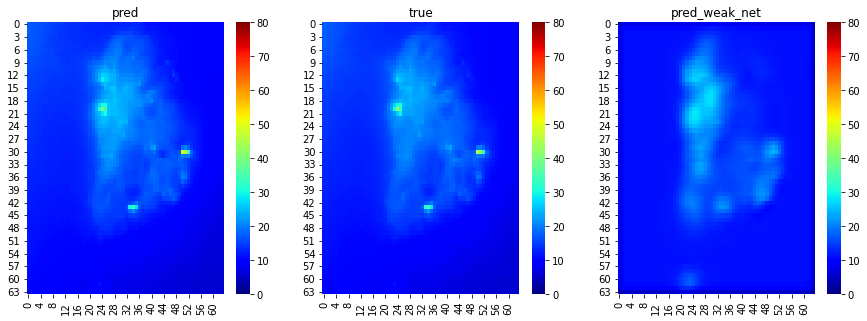

In [ ]:
i = 4
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)